# Setup

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from aeon.classification.feature_based import Catch22Classifier
from aeon.classification.dummy import DummyClassifier

from f1_etl import SessionConfig, DataConfig, create_safety_car_dataset
from f1_etl.config import create_season_configs, create_multi_session_configs

In [12]:
def detect_window_contamination_by_features(X, metadata, feature_names):
    """
    Detect cross-session contamination by analyzing feature discontinuities
    that would indicate session boundaries within individual windows.
    
    This examines the actual telemetry values rather than just timestamps.
    """
    print("=== WINDOW CONTAMINATION ANALYSIS BY FEATURES ===\n")
    
    contamination_found = False
    suspicious_sequences = []
    
    # Find features that are good indicators of session boundaries
    # Speed and Distance are excellent indicators because they reset between sessions
    speed_idx = None
    distance_idx = None
    
    if 'Speed' in feature_names:
        speed_idx = feature_names.index('Speed')
    if 'Distance' in feature_names:
        distance_idx = feature_names.index('Distance')
    
    print(f"Analyzing {len(X)} sequences...")
    print(f"Feature indices - Speed: {speed_idx}, Distance: {distance_idx}")
    print()
    
    for i in range(min(1000, len(X))):  # Sample first 1000 sequences for performance
        sequence = X[i]
        meta = metadata[i]
        session_id = meta['SessionId']
        
        # Analyze feature discontinuities that suggest session boundaries
        discontinuities = []
        
        # Check Speed feature for impossible jumps
        if speed_idx is not None:
            speed_values = sequence[:, speed_idx]
            speed_diffs = np.abs(np.diff(speed_values))
            
            # F1 cars can't change speed by more than ~100 km/h in one time step
            impossible_speed_changes = speed_diffs > 100
            if np.any(impossible_speed_changes):
                jump_indices = np.where(impossible_speed_changes)[0]
                for jump_idx in jump_indices:
                    discontinuities.append({
                        'feature': 'Speed',
                        'position': jump_idx,
                        'from_value': speed_values[jump_idx],
                        'to_value': speed_values[jump_idx + 1],
                        'change': speed_diffs[jump_idx]
                    })
        
        # Check Distance feature for resets (distance going backwards significantly)
        if distance_idx is not None:
            distance_values = sequence[:, distance_idx]
            distance_diffs = np.diff(distance_values)
            
            # Distance should generally increase during a session
            # Large negative jumps suggest a session boundary
            large_backwards_jumps = distance_diffs < -1000  # More than 1km backwards
            if np.any(large_backwards_jumps):
                jump_indices = np.where(large_backwards_jumps)[0]
                for jump_idx in jump_indices:
                    discontinuities.append({
                        'feature': 'Distance',
                        'position': jump_idx,
                        'from_value': distance_values[jump_idx],
                        'to_value': distance_values[jump_idx + 1],
                        'change': distance_diffs[jump_idx]
                    })
        
        # Report sequences with suspicious discontinuities
        if discontinuities:
            contamination_found = True
            suspicious_sequences.append({
                'sequence_id': i,
                'session_id': session_id,
                'start_time': meta['start_time'],
                'end_time': meta['end_time'],
                'discontinuities': discontinuities
            })
    
    # Report findings
    if contamination_found:
        print(f"🚨 CONTAMINATION DETECTED in {len(suspicious_sequences)} sequences!")
        print()
        
        for seq_info in suspicious_sequences[:10]:  # Show first 10
            print(f"Sequence {seq_info['sequence_id']} ({seq_info['session_id']}):")
            print(f"  Time: {seq_info['start_time']} to {seq_info['end_time']}")
            for disc in seq_info['discontinuities']:
                print(f"  ⚠️  {disc['feature']} jump at position {disc['position']}: "
                      f"{disc['from_value']:.1f} → {disc['to_value']:.1f} "
                      f"(change: {disc['change']:.1f})")
            print()
        
        if len(suspicious_sequences) > 10:
            print(f"... and {len(suspicious_sequences) - 10} more suspicious sequences")
        
        return False
    else:
        print("✅ No obvious window contamination detected")
        print("All sequences show realistic feature continuity")
        return True


def detect_session_boundary_crossings(metadata):
    """
    Simple check: look for sequences where consecutive samples in the 
    final dataset come from different sessions, which would indicate
    that the windowing process created sequences spanning sessions.
    """
    print("=== SESSION BOUNDARY CROSSING ANALYSIS ===\n")
    
    # Create a mapping of sequence index to session
    sequence_sessions = [(i, meta['SessionId']) for i, meta in enumerate(metadata)]
    
    # Sort by the actual order sequences appear in the final dataset
    # (this should match the order they were created)
    
    # Look for patterns that suggest session mixing
    session_transitions = []
    current_session = sequence_sessions[0][1]
    
    for i, (seq_idx, session_id) in enumerate(sequence_sessions):
        if session_id != current_session:
            session_transitions.append({
                'position': i,
                'from_session': current_session,
                'to_session': session_id,
                'sequence_idx': seq_idx
            })
            current_session = session_id
    
    print(f"Total sequences: {len(sequence_sessions)}")
    print(f"Session transitions in sequence order: {len(session_transitions)}")
    
    if session_transitions:
        print("\nSession transitions detected:")
        for trans in session_transitions:
            print(f"  Position {trans['position']}: {trans['from_session']} → {trans['to_session']}")
        
        # This alone doesn't prove contamination, but helps understand the data structure
        print(f"\nNote: {len(session_transitions)} transitions found.")
        print("This shows how sequences from different sessions are distributed.")
        print("Cross-session contamination would show as sequences with mixed session data.")
    else:
        print("All sequences come from the same session - unexpected for multi-session data!")
    
    return session_transitions


def comprehensive_contamination_check(X, metadata):
    """
    Comprehensive check combining multiple approaches to definitively
    determine if cross-session contamination exists.
    """
    print("=== COMPREHENSIVE CONTAMINATION CHECK ===\n")
    
    # Extract feature names from metadata
    feature_names = metadata[0]['features_used'] if metadata else []
    print(f"Feature names: {feature_names}\n")
    
    # Run all checks
    print("1. Checking session boundary crossings...")
    session_transitions = detect_session_boundary_crossings(metadata)
    print()
    
    print("2. Checking for feature discontinuities...")
    no_feature_contamination = detect_window_contamination_by_features(X, metadata, feature_names)
    print()
    
    # Summary
    print("=== SUMMARY ===")
    if session_transitions and not no_feature_contamination:
        print("🚨 CROSS-SESSION CONTAMINATION CONFIRMED")
        print("Both session mixing and feature discontinuities detected")
    elif not no_feature_contamination:
        print("⚠️  POSSIBLE CONTAMINATION")
        print("Feature discontinuities detected (may be data artifacts)")
    elif session_transitions:
        print("✅ NO CONTAMINATION DETECTED")
        print("Session mixing in sequence order is normal for multi-session datasets")
    else:
        print("✅ NO CONTAMINATION DETECTED")
        print("Clean session boundaries and feature continuity")
    
    return no_feature_contamination and len(session_transitions) > 0

In [19]:
def comprehensive_evaluation(y_true, y_pred, class_names, title="Model Evaluation"):
    """Comprehensive evaluation focusing on F1-score and handling class imbalance"""
    
    # Get unique classes present in the data
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [class_names[i] for i in unique_classes if i < len(class_names)]
    
    print(f"\n=== {title} ===")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=present_class_names, 
                yticklabels=present_class_names)
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    
    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    
    # Per-class F1 scores
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0, labels=unique_classes)
    print(f"\nPer-class F1-scores:")
    for i, f1 in enumerate(f1_per_class):
        class_idx = unique_classes[i]
        class_name = present_class_names[i] if i < len(present_class_names) else f"Class_{class_idx}"
        print(f"  {class_name}: {f1:.4f}")
    
    # Class distribution
    print(f"\nClass distribution:")
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    for class_idx, count in zip(unique_true, counts_true):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class_{class_idx}"
        print(f"  {class_name}: {count} ({count/len(y_true)*100:.1f}%)")
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'unique_classes': unique_classes
    }

# Single Race

In [34]:
### Basic Usage - Single Race

# Define a single race session
session = SessionConfig(
    year=2024,
    race="Monaco Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="./f1_cache"
)

# Generate the dataset
dataset = create_safety_car_dataset(
    config=config,
    window_size=100,
    prediction_horizon=10
)

print(f"Generated {dataset['config']['n_sequences']} sequences")
print(f"Features: {dataset['config']['feature_names']}")
print(f"Class distribution: {dataset['class_distribution']}")

Loading session: 2024 Monaco Grand Prix R
Loading from cache: f1_cache/2024_Monaco_Grand_Prix_R.pkl


2025-06-28 14:57:27,124 - f1_etl - INFO - Processing 1833280 total telemetry rows
2025-06-28 14:57:27,126 - f1_etl - INFO - Grouping by: ['SessionId', 'Driver']
2025-06-28 14:57:35,755 - f1_etl - INFO - Total sequences generated: 36640
2025-06-28 14:57:35,915 - f1_etl - INFO - Generated 36640 sequences with shape (36640, 100, 9)
2025-06-28 14:57:35,943 - f1_etl - INFO - No missing values detected, skipping imputation


Generated 36640 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': np.int64(29900), 'red': np.int64(5780), 'safety_car': np.int64(320), 'yellow': np.int64(640)}


In [36]:
X = dataset['X']
y = dataset['y']
metadata = dataset['metadata']

comprehensive_contamination_check(X, metadata)

=== COMPREHENSIVE CONTAMINATION CHECK ===

Feature names: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']

1. Checking session boundary crossings...
=== SESSION BOUNDARY CROSSING ANALYSIS ===

Total sequences: 36640
Session transitions in sequence order: 0
All sequences come from the same session - unexpected for multi-session data!

2. Checking for feature discontinuities...
=== WINDOW CONTAMINATION ANALYSIS BY FEATURES ===

Analyzing 36640 sequences...
Feature indices - Speed: 0, Distance: 7

✅ No obvious window contamination detected
All sequences show realistic feature continuity

=== SUMMARY ===
✅ NO CONTAMINATION DETECTED
Clean session boundaries and feature continuity


False

In [37]:
# Split data for training with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [38]:
from aeon.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use Speed (index 0) - likely most predictive for safety car events
X_train_speed = X_train[:, :, 0:1]  # Keep as 3D with single channel
X_test_speed = X_test[:, :, 0:1]

In [28]:
clf = Catch22Classifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    outlier_norm=True,
    random_state=42,
)

clf.fit(X_train_speed, y_train)
y_pred = clf.predict(X_test_speed)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ZeroDivisionError: division by zero

In [39]:
import pandas as pd

print("Mean:", np.mean(X_train_speed))
print("Std:", np.std(X_train_speed))
print("Min:", np.min(X_train_speed))
print("Max:", np.max(X_train_speed))
print("Median:", np.median(X_train_speed))
print("Variance:", np.var(X_train_speed))

Mean: -0.0009362646183320195


Std: 0.999898969611483
Min: -0.783916366570298
Max: 2.739011115758356
Median: -0.783916366570298
Variance: 0.9997979494301054


In [40]:
# Check for problematic sequences
X_speed = X[:, :, 0]  # Speed feature only

print("=== SPEED DATA DIAGNOSTICS ===")
print(f"Shape: {X_speed.shape}")
print(f"Overall min/max: {X_speed.min():.6f} / {X_speed.max():.6f}")

# Check for constant sequences
constant_sequences = []
near_constant_sequences = []

for i in range(X_speed.shape[0]):
    seq = X_speed[i, :]
    seq_std = np.std(seq)
    seq_range = np.max(seq) - np.min(seq)
    
    if seq_std == 0:
        constant_sequences.append(i)
    elif seq_std < 1e-6:
        near_constant_sequences.append(i)

print(f"Constant sequences: {len(constant_sequences)}")
print(f"Near-constant sequences (std < 1e-6): {len(near_constant_sequences)}")

# Check a few examples
if len(constant_sequences) > 0:
    print(f"\nFirst constant sequence (index {constant_sequences[0]}):")
    print(X_speed[constant_sequences[0], :10])  # First 10 values

# Filter out problematic sequences
valid_indices = [i for i in range(X_speed.shape[0]) 
                if i not in constant_sequences and i not in near_constant_sequences]

print(f"\nValid sequences: {len(valid_indices)} out of {X_speed.shape[0]}")

=== SPEED DATA DIAGNOSTICS ===
Shape: (36640, 100)
Overall min/max: -0.783916 / 2.739011
Constant sequences: 18937
Near-constant sequences (std < 1e-6): 4

First constant sequence (index 0):
[-0.78391637 -0.78391637 -0.78391637 -0.78391637 -0.78391637 -0.78391637
 -0.78391637 -0.78391637 -0.78391637 -0.78391637]

Valid sequences: 17699 out of 36640


In [41]:
raw_telemetry = dataset['raw_telemetry']
speed_raw = raw_telemetry['Speed'].values

print(f"Raw Speed stats:")
print(f"  Min: {speed_raw.min():.3f}")
print(f"  Max: {speed_raw.max():.3f}")
print(f"  Mean: {speed_raw.mean():.3f}")
print(f"  Std: {speed_raw.std():.3f}")

# Check for zero/constant speeds in raw data
zero_speeds = np.sum(speed_raw == 0)
print(f"\nZero speeds in raw data: {zero_speeds} ({zero_speeds/len(speed_raw)*100:.2f}%)")

# Check if constant value maps to zero speed
global_mean = speed_raw.mean()
global_std = speed_raw.std()
expected_normalized_zero = (0 - global_mean) / global_std
print(f"\nExpected normalized value for 0 speed: {expected_normalized_zero:.6f}")
print(f"Actual constant value in sequences: {-0.783916:.6f}")
print(f"Match: {abs(expected_normalized_zero - (-0.783916)) < 1e-5}")


Raw Speed stats:
  Min: 0.000
  Max: 295.000
  Mean: 65.626
  Std: 83.719

Zero speeds in raw data: 973410 (53.10%)

Expected normalized value for 0 speed: -0.783888
Actual constant value in sequences: -0.783916
Match: False


The **division by zero error** occurs because Catch22 computes statistical features that involve dividing by standard deviation or other measures of variability. When a time series is constant (all values identical), these calculations fail:

## Specific Catch22 Features That Fail:

1. **Standard deviation-based features**: `std = 0` → division by zero
2. **Coefficient of variation**: `mean/std` → `value/0` 
3. **Z-score calculations**: `(x - mean)/std` → `(x - value)/0`
4. **Autocorrelation features**: Require variance for normalization
5. **Distribution shape features**: Need variation to compute skewness/kurtosis

## Example of What's Happening:
```python
# This is essentially what's in your constant sequences
constant_sequence = np.full(100, -0.783916)  # All values identical

# Catch22 tries to compute features like:
std = np.std(constant_sequence)  # = 0.0
coeff_var = np.mean(constant_sequence) / std  # = -0.783916 / 0.0 → ZeroDivisionError

# Or autocorrelation normalization:
normalized = (constant_sequence - np.mean(constant_sequence)) / std  # → division by 0
```

## Why This Matters for F1 Data:
- **18,937 out of 36,640 sequences** are constant (cars not moving)
- These represent valid F1 states (pit stops, grid formation, etc.)
- But they're **mathematically degenerate** for time series feature extraction

## Solutions:
1. **Filter them out** (lose stationary periods but gain usable features)
2. **Use different features** (RPM/Throttle might have variation even when speed = 0)
3. **Switch algorithms** (use classifiers that handle constant sequences, like ROCKET)

The fundamental issue: **Catch22 assumes time series have temporal variation**. Constant sequences violate this assumption and break the mathematical operations inside the feature extraction.

# Take 2

Released `f1-etl@v0.2.1` to enable modular composition of ETL steps.

In [4]:
def create_catch22_dataset(config: DataConfig) -> Dict[str, Any]:
   """
   Create dataset optimized for Catch22 classifier
   - Disables missing value handling (Catch22 can handle internally)
   - Uses per-sequence normalization to preserve variation
   """
   return create_safety_car_dataset(
       config=config,
       window_size=100,
       prediction_horizon=10,
       handle_non_numeric="encode",
       handle_missing=False,  # Catch22 handles missing values internally
       missing_strategy="forward_fill",
       normalize=True,
       normalization_method="per_sequence",
       target_column="TrackStatus",
       enable_debug=False,
   )

In [4]:
!uv pip list | grep f1

Using Python 3.11.11 environment at: /Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv
f1-etl                  0.2.2
fastf1                  3.5.3


In [9]:
### Basic Usage - Single Race

# Define a single race session
session = SessionConfig(
    year=2024,
    race="Monaco Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="./f1_cache"
)

# Generate the dataset
# dataset = create_safety_car_dataset(
#     config=config,
#     window_size=100,
#     prediction_horizon=10
# )
dataset = create_catch22_dataset(config=config)

print(f"Generated {dataset['config']['n_sequences']} sequences")
print(f"Features: {dataset['config']['feature_names']}")
print(f"Class distribution: {dataset['class_distribution']}")

2025-06-28 16:00:34,332 - f1_etl - INFO - Preprocessing configuration:
2025-06-28 16:00:34,334 - f1_etl - INFO -   Missing values: disabled (forward_fill)
2025-06-28 16:00:34,334 - f1_etl - INFO -   Normalization: enabled (per_sequence)


Loading session: 2024 Monaco Grand Prix R
Loading from cache: f1_cache/2024_Monaco_Grand_Prix_R.pkl


2025-06-28 16:00:39,673 - f1_etl - INFO - Processing 1833280 total telemetry rows
2025-06-28 16:00:39,676 - f1_etl - INFO - Grouping by: ['SessionId', 'Driver']
2025-06-28 16:00:47,730 - f1_etl - INFO - Total sequences generated: 36640
2025-06-28 16:00:47,878 - f1_etl - INFO - Generated 36640 sequences with shape (36640, 100, 9)
2025-06-28 16:00:47,878 - f1_etl - INFO - Missing value handling disabled
2025-06-28 16:00:47,910 - f1_etl - INFO - Applying normalization with method: per_sequence


Generated 36640 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': np.int64(29900), 'red': np.int64(5780), 'safety_car': np.int64(320), 'yellow': np.int64(640)}


In [20]:
X = dataset['X']
X_aeon = X.transpose(0, 2, 1)
y = dataset['y']
metadata = dataset['metadata']

comprehensive_contamination_check(X_aeon, metadata)

=== COMPREHENSIVE CONTAMINATION CHECK ===

Feature names: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']

1. Checking session boundary crossings...
=== SESSION BOUNDARY CROSSING ANALYSIS ===

Total sequences: 36640
Session transitions in sequence order: 0
All sequences come from the same session - unexpected for multi-session data!

2. Checking for feature discontinuities...
=== WINDOW CONTAMINATION ANALYSIS BY FEATURES ===

Analyzing 36640 sequences...
Feature indices - Speed: 0, Distance: 7

✅ No obvious window contamination detected
All sequences show realistic feature continuity

=== SUMMARY ===
✅ NO CONTAMINATION DETECTED
Clean session boundaries and feature continuity


False

In [26]:
X_aeon.shape

(36640, 9, 100)

In [ ]:
# Split data for training with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_aeon, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Use Speed (index 0) - likely most predictive for safety car events
X_train_speed = X_train[:, 0:1, :]  # Keep as 3D with single channel
X_test_speed = X_test[:, 0:1, :]

In [28]:
clf = Catch22Classifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    outlier_norm=True,
    random_state=42,
)

clf.fit(X_train_speed, y_train)
y_pred = clf.predict(X_test_speed)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8163

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5980
           1       1.00      0.00      0.00      1156
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00       128

    accuracy                           0.82      7328
   macro avg       0.45      0.25      0.23      7328
weighted avg       0.82      0.82      0.73      7328



/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.p

=== CURRENT TEST SET EVALUATION ===


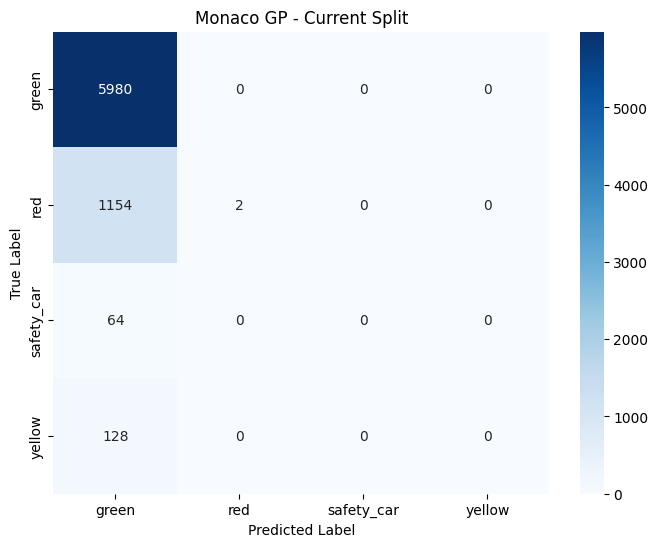


Confusion Matrix:
[[5980    0    0    0]
 [1154    2    0    0]
 [  64    0    0    0]
 [ 128    0    0    0]]

Class distribution in test set:
  green: 5980 samples (81.6%)
  red: 1156 samples (15.8%)
  safety_car: 64 samples (0.9%)
  yellow: 128 samples (1.7%)

Predictions distribution:
  green: 7326 predictions (100.0%)
  red: 2 predictions (0.0%)
  safety_car: 0 predictions (0.0%)
  yellow: 0 predictions (0.0%)


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix for current test set
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return cm

# Get class names from label encoder
label_encoder = dataset['label_encoder']
class_names = ['green', 'red', 'safety_car', 'yellow']  # Based on your earlier output

print("=== CURRENT TEST SET EVALUATION ===")
cm = plot_confusion_matrix(y_test, y_pred, class_names, "Monaco GP - Current Split")

# Print detailed analysis
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClass distribution in test set:")
for i, name in enumerate(class_names):
    count = np.sum(y_test == i)
    print(f"  {name}: {count} samples ({count/len(y_test)*100:.1f}%)")

print(f"\nPredictions distribution:")
for i, name in enumerate(class_names):
    count = np.sum(y_pred == i)
    print(f"  {name}: {count} predictions ({count/len(y_pred)*100:.1f}%)")

In [30]:
different_race_config = DataConfig(
    sessions=[SessionConfig(
        year=2024,
        race="Spanish Grand Prix",  # Different race
        session_type="R"
    )],
    cache_dir="./f1_cache"
)

try:
    # Generate dataset for different race
    dataset_validation = create_catch22_dataset(
        config=different_race_config,
        window_size=100,
        prediction_horizon=10
    )
    
    X_val = dataset_validation['X'].transpose(0, 2, 1)  # Transpose for Aeon format
    y_val = dataset_validation['y']
    
    print(f"Validation dataset shape: {X_val.shape}")
    print(f"Validation class distribution: {dataset_validation['class_distribution']}")
    
    # Extract speed feature for validation
    X_val_speed = X_val[:, 0:1, :]
    
    # Predict on different race
    y_val_pred = clf.predict(X_val_speed)
    
    print(f"\nCross-race validation accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print("\nCross-race Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))
    
    # Plot confusion matrix for validation
    cm_val = plot_confusion_matrix(y_val, y_val_pred, class_names, "Spanish GP - Cross-Race Validation")
    
except Exception as e:
    print(f"Error loading validation race: {e}")
    print("Try a different race or check available data")

# 3. Check if model is just predicting majority class
print("\n=== BASELINE COMPARISON ===")
from sklearn.dummy import DummyClassifier

# Majority class baseline
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_speed, y_train)
y_dummy = dummy.predict(X_test_speed)

print(f"Majority class baseline accuracy: {accuracy_score(y_test, y_dummy):.4f}")
print("Your model vs baseline:")
print(f"  Catch22: {accuracy_score(y_test, y_pred):.4f}")
print(f"  Baseline: {accuracy_score(y_test, y_dummy):.4f}")
print(f"  Improvement: {accuracy_score(y_test, y_pred) - accuracy_score(y_test, y_dummy):.4f}")

2025-06-28 16:14:24,300 - f1_etl - INFO - Preprocessing configuration:
2025-06-28 16:14:24,302 - f1_etl - INFO -   Missing values: disabled (forward_fill)
2025-06-28 16:14:24,302 - f1_etl - INFO -   Normalization: enabled (per_sequence)
req         WARNING 	DEFAULT CACHE ENABLED! (2.5 GB) /Users/seansica/Library/Caches/fastf1


Loading session: 2024 Spanish Grand Prix R


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14

Validation dataset shape: (27740, 9, 100)
Validation class distribution: {'green': np.int64(26100), 'yellow': np.int64(1640)}

Cross-race validation accuracy: 0.9401

Cross-race Classification Report:
Error loading validation race: Number of classes, 2, does not match size of target_names, 4. Try specifying the labels parameter
Try a different race or check available data

=== BASELINE COMPARISON ===
Majority class baseline accuracy: 0.8160
Your model vs baseline:
  Catch22: 0.8163
  Baseline: 0.8160
  Improvement: 0.0003


=== MONACO GP EVALUATION ===

=== Monaco GP ===


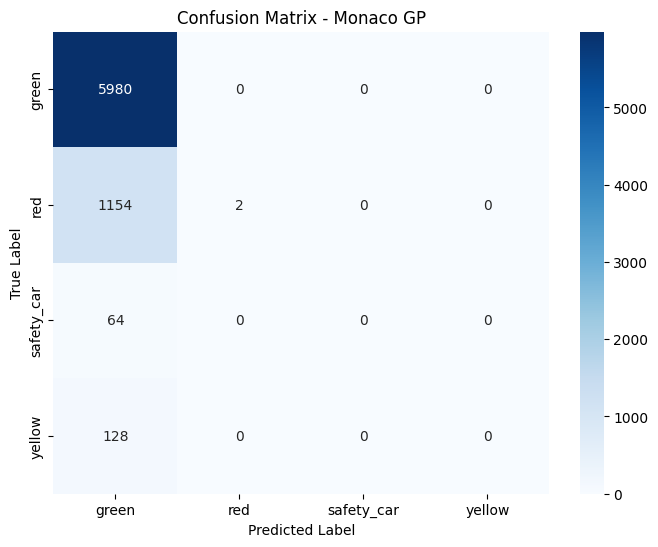

Accuracy: 0.8163
F1-Score (Macro): 0.2256
F1-Score (Micro): 0.8163
F1-Score (Weighted): 0.7340

Per-class F1-scores:
  green: 0.8988
  red: 0.0035
  safety_car: 0.0000
  yellow: 0.0000

Class distribution:
  green: 5980 (81.6%)
  red: 1156 (15.8%)
  safety_car: 64 (0.9%)
  yellow: 128 (1.7%)

=== SPANISH GP CROSS-VALIDATION ===

=== Spanish GP ===


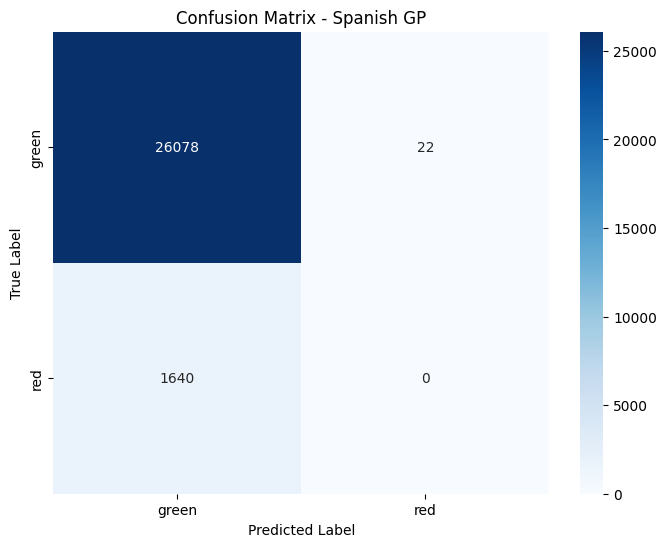

Accuracy: 0.9401
F1-Score (Macro): 0.4846
F1-Score (Micro): 0.9401
F1-Score (Weighted): 0.9118

Per-class F1-scores:
  green: 0.9691
  red: 0.0000

Class distribution:
  green: 26100 (94.1%)
  red: 1640 (5.9%)

=== BASELINE COMPARISON ===

=== Baseline (Most Frequent) ===


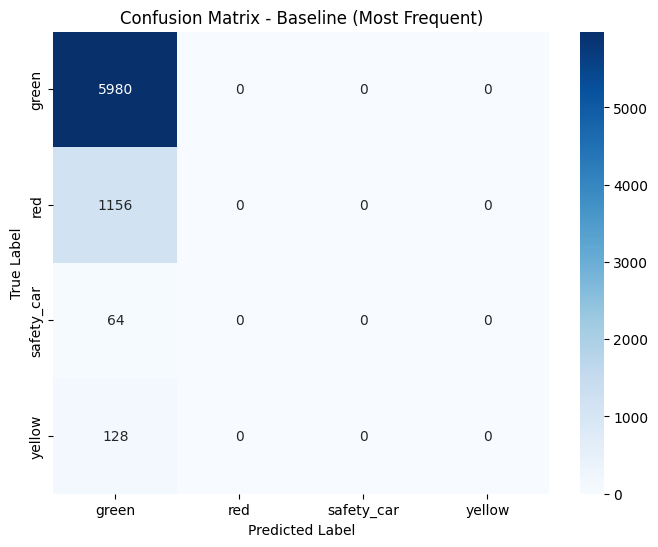

Accuracy: 0.8160
F1-Score (Macro): 0.2247
F1-Score (Micro): 0.8160
F1-Score (Weighted): 0.7334

Per-class F1-scores:
  green: 0.8987
  red: 0.0000
  safety_car: 0.0000
  yellow: 0.0000

Class distribution:
  green: 5980 (81.6%)
  red: 1156 (15.8%)
  safety_car: 64 (0.9%)
  yellow: 128 (1.7%)

=== SUMMARY COMPARISON ===
Metric               Catch22    Baseline   Difference
--------------------------------------------------
Accuracy             0.8163     0.8160     0.0003    
F1-Macro             0.2256     0.2247     0.0009    
F1-Weighted          0.7340     0.7334     0.0007    

=== ANALYSIS ===
⚠️  Model performs similarly to baseline classifier

Recommendations:
1. Try different features (RPM, Throttle instead of Speed)
2. Balance the dataset or use class weights
3. Focus on binary classification (safety events vs normal)
4. Use different time windows or prediction horizons


In [31]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def comprehensive_evaluation(y_true, y_pred, class_names, title="Model Evaluation"):
    """Comprehensive evaluation focusing on F1-score and handling class imbalance"""
    
    # Get unique classes present in the data
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [class_names[i] for i in unique_classes if i < len(class_names)]
    
    print(f"\n=== {title} ===")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=present_class_names, 
                yticklabels=present_class_names)
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    
    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    
    # Per-class F1 scores
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0, labels=unique_classes)
    print(f"\nPer-class F1-scores:")
    for i, f1 in enumerate(f1_per_class):
        class_idx = unique_classes[i]
        class_name = present_class_names[i] if i < len(present_class_names) else f"Class_{class_idx}"
        print(f"  {class_name}: {f1:.4f}")
    
    # Class distribution
    print(f"\nClass distribution:")
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    for class_idx, count in zip(unique_true, counts_true):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class_{class_idx}"
        print(f"  {class_name}: {count} ({count/len(y_true)*100:.1f}%)")
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'unique_classes': unique_classes
    }

# Evaluate Monaco GP (original test)
class_names = ['green', 'red', 'safety_car', 'yellow']
print("=== MONACO GP EVALUATION ===")
monaco_results = comprehensive_evaluation(y_test, y_pred, class_names, "Monaco GP")

# Evaluate Spanish GP (cross-validation)
if 'y_val' in locals() and 'y_val_pred' in locals():
    print("\n=== SPANISH GP CROSS-VALIDATION ===")
    spanish_results = comprehensive_evaluation(y_val, y_val_pred, class_names, "Spanish GP")

# Compare with baseline
print("\n=== BASELINE COMPARISON ===")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_speed, y_train)
y_dummy = dummy.predict(X_test_speed)

baseline_results = comprehensive_evaluation(y_test, y_dummy, class_names, "Baseline (Most Frequent)")

# Summary comparison
print("\n=== SUMMARY COMPARISON ===")
print(f"{'Metric':<20} {'Catch22':<10} {'Baseline':<10} {'Difference':<10}")
print("-" * 50)
print(f"{'Accuracy':<20} {monaco_results['accuracy']:<10.4f} {baseline_results['accuracy']:<10.4f} {monaco_results['accuracy'] - baseline_results['accuracy']:<10.4f}")
print(f"{'F1-Macro':<20} {monaco_results['f1_macro']:<10.4f} {baseline_results['f1_macro']:<10.4f} {monaco_results['f1_macro'] - baseline_results['f1_macro']:<10.4f}")
print(f"{'F1-Weighted':<20} {monaco_results['f1_weighted']:<10.4f} {baseline_results['f1_weighted']:<10.4f} {monaco_results['f1_weighted'] - baseline_results['f1_weighted']:<10.4f}")

# Check if model is learning anything meaningful
print(f"\n=== ANALYSIS ===")
if monaco_results['f1_macro'] < 0.1:
    print("⚠️  Model is not learning meaningful patterns (F1-macro < 0.1)")
if abs(monaco_results['accuracy'] - baseline_results['accuracy']) < 0.01:
    print("⚠️  Model performs similarly to baseline classifier")
if len(np.unique(y_pred)) == 1:
    print("⚠️  Model is only predicting one class")

print(f"\nRecommendations:")
print("1. Try different features (RPM, Throttle instead of Speed)")
print("2. Balance the dataset or use class weights")
print("3. Focus on binary classification (safety events vs normal)")
print("4. Use different time windows or prediction horizons")

# Whole Season

In [5]:
# Generate configs for all 2024 races
race_configs = create_season_configs(2024, session_types=['R'])

# Create dataset configuration
config_2024_whole_season = DataConfig(
    sessions=race_configs,
    cache_dir="./f1_cache"
)

req         WARNING 	DEFAULT CACHE ENABLED! (2.5 GB) /Users/seansica/Library/Caches/fastf1
2025-06-29 11:05:12,196 - f1_etl - INFO - Generated 24 SessionConfig objects for 2024 season


In [9]:
dataset = create_catch22_dataset(config=config_2024_whole_season)

print(f"Generated {dataset['config']['n_sequences']} sequences")
print(f"Features: {dataset['config']['feature_names']}")
print(f"Class distribution: {dataset['class_distribution']}")

2025-06-29 11:06:41,838 - f1_etl - INFO - Preprocessing configuration:
2025-06-29 11:06:41,839 - f1_etl - INFO -   Missing values: disabled (forward_fill)
2025-06-29 11:06:41,839 - f1_etl - INFO -   Normalization: enabled (per_sequence)
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loading session: 2024 Bahrain Grand Prix R


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_statu

Loading session: 2024 Saudi Arabian Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Australian Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Japanese Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Chinese Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


Loading session: 2024 Miami Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Emilia Romagna Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loading session: 2024 Monaco Grand Prix R
Loading from cache: f1_cache/2024_Monaco_Grand_Prix_R.pkl
Loading session: 2024 Canadian Grand Prix R


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loading session: 2024 Spanish Grand Prix R
Loading from cache: f1_cache/2024_Spanish_Grand_Prix_R.pkl
Loading session: 2024 Austrian Grand Prix R


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data

Loading session: 2024 British Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Hungarian Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Belgian Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Dutch Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Italian Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Azerbaijan Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Singapore Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
co

Loading session: 2024 United States Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Mexico City Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 São Paulo Grand Prix R


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            

Loading session: 2024 Las Vegas Grand Prix R


core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 30: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 77: Lap timing integrity check failed for 2 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 63 completed the race distance 

Loading session: 2024 Qatar Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '10', '55', '14', '24', '20', '4', '77', '44', '22', '30', '23', '27', '11', '18', '43', '31']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading session: 2024 Abu Dhabi Grand Prix R


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']
2025-06-29 11:09:12,154 - f1_etl - INFO - Processing 33442517 total telemetry rows
2025-06-29 11:09:12,165 - f1_etl - INFO - Grouping by: ['SessionId', 'Driver']
2025-06-29 11:11:50,069 - f1_etl - INFO - Total sequences generated: 668036
2025-06-29 11:11:56,225 - f1_etl - INFO - Generated 668036 sequences with shape (668036, 100, 9)
2025-06-29 11:11:56,227 - f1_etl - INFO - Missing value handling disabled
2025-06-29 11:11:57,953 - f1_etl - WARNING - Missing values detected but handling is disabled - may cause issues with some models
2025-06-29 11:11:57,955 - f1_etl - INFO - Applying no

Generated 668036 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': np.int64(614415), 'red': np.int64(13440), 'safety_car': np.int64(19102), 'vsc': np.int64(3956), 'vsc_ending': np.int64(177), 'yellow': np.int64(16946)}


In [13]:
X = dataset['X']
X_aeon = X.transpose(0, 2, 1)
y = dataset['y']
metadata = dataset['metadata']

comprehensive_contamination_check(X_aeon, metadata)

=== COMPREHENSIVE CONTAMINATION CHECK ===

Feature names: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']

1. Checking session boundary crossings...
=== SESSION BOUNDARY CROSSING ANALYSIS ===



Total sequences: 668036
Session transitions in sequence order: 23

Session transitions detected:
  Position 27140: 2024_Abu Dhabi Grand Prix_R → 2024_Australian Grand Prix_R
  Position 51916: 2024_Australian Grand Prix_R → 2024_Austrian Grand Prix_R
  Position 78036: 2024_Austrian Grand Prix_R → 2024_Azerbaijan Grand Prix_R
  Position 104936: 2024_Azerbaijan Grand Prix_R → 2024_Bahrain Grand Prix_R
  Position 133136: 2024_Bahrain Grand Prix_R → 2024_Belgian Grand Prix_R
  Position 157676: 2024_Belgian Grand Prix_R → 2024_British Grand Prix_R
  Position 184396: 2024_British Grand Prix_R → 2024_Canadian Grand Prix_R
  Position 204816: 2024_Canadian Grand Prix_R → 2024_Chinese Grand Prix_R
  Position 234396: 2024_Chinese Grand Prix_R → 2024_Dutch Grand Prix_R
  Position 261836: 2024_Dutch Grand Prix_R → 2024_Emilia Romagna Grand Prix_R
  Position 287856: 2024_Emilia Romagna Grand Prix_R → 2024_Hungarian Grand Prix_R
  Position 315936: 2024_Hungarian Grand Prix_R → 2024_Italian Grand Prix_

True

In [14]:
# Split data for training with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_aeon, y, test_size=0.2, random_state=42, stratify=y
)

# Use Speed (index 0) - likely most predictive for safety car events
X_train_speed = X_train[:, 0:1, :]  # Keep as 3D with single channel
X_test_speed = X_test[:, 0:1, :]

In [15]:
clf = Catch22Classifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    outlier_norm=True,
    random_state=42,
)

clf.fit(X_train_speed, y_train)
y_pred = clf.predict(X_test_speed)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9197

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    122884
           1       0.00      0.00      0.00      2688
           2       0.43      0.01      0.01      3821
           3       0.00      0.00      0.00       791
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00      3389

    accuracy                           0.92    133608
   macro avg       0.22      0.17      0.16    133608
weighted avg       0.86      0.92      0.88    133608



/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seansica/Documents/Development/mids/capstone/datasci-210-2025-summer-formula1/sean/notebooks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: 


=== 2024 Season [R] ===


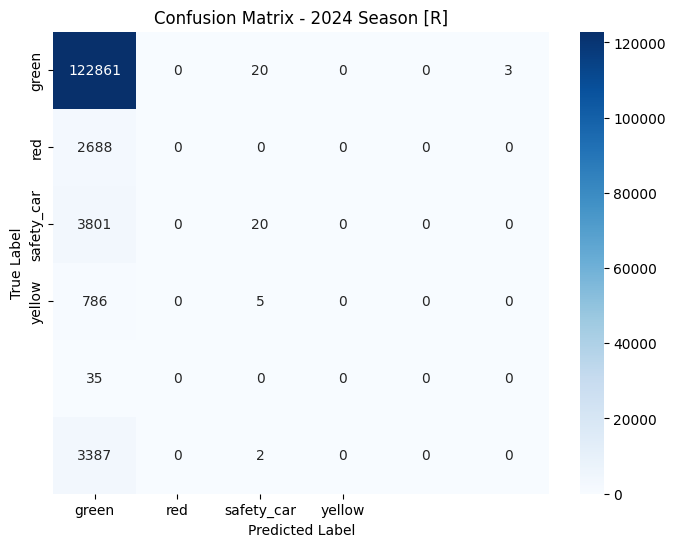

Accuracy: 0.9197
F1-Score (Macro): 0.1614
F1-Score (Micro): 0.9197
F1-Score (Weighted): 0.8816

Per-class F1-scores:
  green: 0.9582
  red: 0.0000
  safety_car: 0.0103
  yellow: 0.0000
  Class_4: 0.0000
  Class_5: 0.0000

Class distribution:
  green: 122884 (92.0%)
  red: 2688 (2.0%)
  safety_car: 3821 (2.9%)
  yellow: 791 (0.6%)
  Class_4: 35 (0.0%)
  Class_5: 3389 (2.5%)


In [21]:
results = comprehensive_evaluation(y_test, y_pred, class_names, "2024 Season [R]")


=== BASELINE COMPARISON ===

=== Baseline (Most Frequent) ===


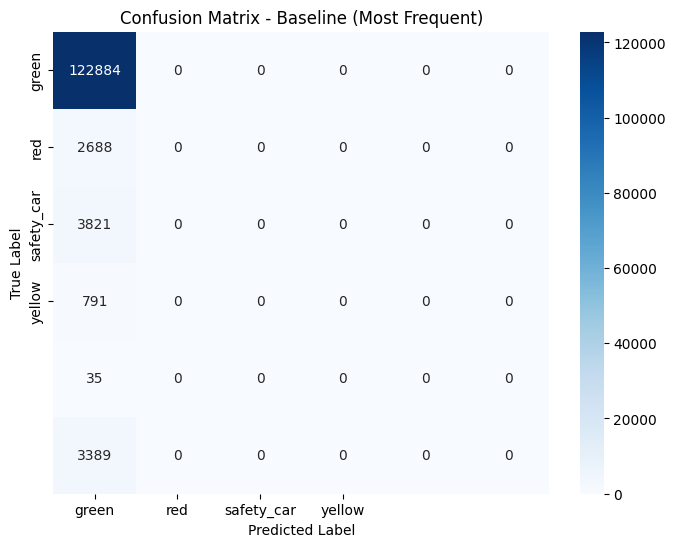

Accuracy: 0.9197
F1-Score (Macro): 0.1597
F1-Score (Micro): 0.9197
F1-Score (Weighted): 0.8813

Per-class F1-scores:
  green: 0.9582
  red: 0.0000
  safety_car: 0.0000
  yellow: 0.0000
  Class_4: 0.0000
  Class_5: 0.0000

Class distribution:
  green: 122884 (92.0%)
  red: 2688 (2.0%)
  safety_car: 3821 (2.9%)
  yellow: 791 (0.6%)
  Class_4: 35 (0.0%)
  Class_5: 3389 (2.5%)

=== SUMMARY COMPARISON ===
Metric               Catch22    Baseline   Difference
--------------------------------------------------
Accuracy             0.9197     0.9197     -0.0000   
F1-Macro             0.1614     0.1597     0.0017    
F1-Weighted          0.8816     0.8813     0.0003    

=== ANALYSIS ===
⚠️  Model performs similarly to baseline classifier


In [23]:
# Compare with baseline
print("\n=== BASELINE COMPARISON ===")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_speed, y_train)
y_dummy = dummy.predict(X_test_speed)

baseline_results = comprehensive_evaluation(y_test, y_dummy, class_names, "Baseline (Most Frequent)")

# Summary comparison
print("\n=== SUMMARY COMPARISON ===")
print(f"{'Metric':<20} {'Catch22':<10} {'Baseline':<10} {'Difference':<10}")
print("-" * 50)
print(f"{'Accuracy':<20} {results['accuracy']:<10.4f} {baseline_results['accuracy']:<10.4f} {results['accuracy'] - baseline_results['accuracy']:<10.4f}")
print(f"{'F1-Macro':<20} {results['f1_macro']:<10.4f} {baseline_results['f1_macro']:<10.4f} {results['f1_macro'] - baseline_results['f1_macro']:<10.4f}")
print(f"{'F1-Weighted':<20} {results['f1_weighted']:<10.4f} {baseline_results['f1_weighted']:<10.4f} {results['f1_weighted'] - baseline_results['f1_weighted']:<10.4f}")

# Check if model is learning anything meaningful
print(f"\n=== ANALYSIS ===")
if results['f1_macro'] < 0.1:
    print("⚠️  Model is not learning meaningful patterns (F1-macro < 0.1)")
if abs(results['accuracy'] - baseline_results['accuracy']) < 0.01:
    print("⚠️  Model performs similarly to baseline classifier")
if len(np.unique(y_pred)) == 1:
    print("⚠️  Model is only predicting one class")

# One Driver

In [ ]:
### Basic Usage - Single Race

# Define a single race session
session = SessionConfig(
    year=2024,
    race="Monaco Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="./f1_cache",
    drivers=["VER"] # <---- ONLY INCLUDE VER DATA
)

# Generate the dataset
dataset = create_safety_car_dataset(
    config=config,
    window_size=100,
    prediction_horizon=10
)

print(f"Generated {dataset['config']['n_sequences']} sequences")
print(f"Features: {dataset['config']['feature_names']}")
print(f"Class distribution: {dataset['class_distribution']}")

# Debugging

In [24]:
dataset.keys()

dict_keys(['X', 'y', 'y_raw', 'metadata', 'label_encoder', 'feature_engineer', 'raw_telemetry', 'class_distribution', 'config'])

In [26]:
dataset['metadata'][0]

{'start_time': Timestamp('2024-12-08 12:06:49.420000'),
 'end_time': Timestamp('2024-12-08 12:07:04.979000'),
 'prediction_time': Timestamp('2024-12-08 12:07:06.295000'),
 'sequence_length': 100,
 'prediction_horizon': 10,
 'features_used': ['Speed',
  'RPM',
  'nGear',
  'Throttle',
  'Brake',
  'X',
  'Y',
  'Distance',
  'DifferentialDistance'],
 'target_column': 'TrackStatus',
 'SessionId': '2024_Abu Dhabi Grand Prix_R',
 'Driver': '1'}

In [27]:
label_encoder = dataset['label_encoder']

In [29]:
label_encoder.get_classes()

array(['green', 'red', 'safety_car', 'vsc', 'vsc_ending', 'yellow'],
      dtype=object)

In [30]:
from sklearn.preprocessing import LabelEncoder


class DriverLabelEncoder:
    """Encodes driver identifiers for consistency"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.is_fitted = False
        self.driver_to_number = {}  # Maps abbreviations to driver numbers
        self.number_to_driver = {}  # Maps driver numbers to abbreviations
    
    def fit_session(self, session) -> 'DriverLabelEncoder':
        """Fit the encoder using session driver data"""
        driver_numbers = session.drivers
        
        for driver_number in driver_numbers:
            driver_info = session.get_driver(driver_number)
            abbreviation = driver_info['Abbreviation']
            
            self.driver_to_number[abbreviation] = driver_number
            self.number_to_driver[driver_number] = abbreviation
        
        # Fit encoder on abbreviations for consistent encoding
        abbreviations = list(self.driver_to_number.keys())
        self.label_encoder.fit(abbreviations)
        self.is_fitted = True
        return self
    
    def transform_driver_to_number(self, drivers):
        """Transform driver abbreviations to driver numbers"""
        if not self.is_fitted:
            raise ValueError("Encoder not fitted")
        return [self.driver_to_number[driver] for driver in drivers]
    
    def transform_number_to_driver(self, numbers):
        """Transform driver numbers to abbreviations"""
        if not self.is_fitted:
            raise ValueError("Encoder not fitted")
        return [self.number_to_driver[number] for number in numbers]

In [ ]:
driver_label_encoder = DriverLabelEncoder()

NameError: name 'session' is not defined

In [35]:
import fastf1
session = fastf1.get_session(2024, 'Saudi Arabian Grand Prix', 'R')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


In [36]:
driver_label_encoder.fit_session(session)

In [38]:
driver_label_encoder.number_to_driver

{'1': 'VER',
 '11': 'PER',
 '16': 'LEC',
 '81': 'PIA',
 '14': 'ALO',
 '63': 'RUS',
 '38': 'BEA',
 '4': 'NOR',
 '44': 'HAM',
 '27': 'HUL',
 '23': 'ALB',
 '20': 'MAG',
 '31': 'OCO',
 '2': 'SAR',
 '22': 'TSU',
 '3': 'RIC',
 '77': 'BOT',
 '24': 'ZHO',
 '18': 'STR',
 '10': 'GAS'}